In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Define calibration path and files
calibration_files = 'camera_cal/calibration*.jpg'

# Define calibration checkerboard dimensions
calibration_dim = (9,6)

# Define test image filename
test_filename = 'test_images/test3.jpg'

# Define test straight image filename
straight_filename = 'test_images/straight_lines1.jpg'

# Define test curved image filename
curved_filename = 'test_images/test3.jpg'

# Manually selected four points forming a quadrilateral from the "straight line" image file,
# 'test_images/straight_lines1.jpg'
perspective_src = np.float32(
    [[586.0, 456.5],
     [695.5, 456.5],
     [206., 720.],
     [1099., 720.]])
perspective_dst = np.float32(
    [[290.,  0.],
     [1099., 0.],
     [290.,  720.],
     [1099., 720.]])

In [2]:
# Calibrate using checkerboard
# returns ret, mtx, dist, rvecs, tvecs
def calibrate(calibration_files, calibration_dim, plot=None):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    x = calibration_dim[0]
    y = calibration_dim[1]
    objp = np.zeros((x*y,3), np.float32)
    objp[:,:2] = np.mgrid[0:x, 0:y].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob(calibration_files)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
    
        # use cv2.COLOR_BGR2GRAY b/c we read in with cv2.imread
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x,y), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        
        if plot == True:
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (x,y), corners, ret)

    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
            
# Test Undistort a given image given a distortion matrix
def test_undistort(imgpath, mtx, dist):
    img = cv2.imread(imgpath)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Distorted Image")
    plt.show()
    plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    plt.title("Undistorted Image")
    plt.show()
    
def compute_sobel_grad_binary(img, orient='x', sobel_kernel=3, threshold=(0,255)):
    # use cv2.COLOR_BGR2GRAY b/c we read in with cv2.imread
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1

    # Return the result
    return binary_output

# Define a function to threshod an image based on Sobel magnitude
def compute_sobel_mag_binary(img, sobel_kernel=3, threshold=(0,255)):
    # use cv2.COLOR_BGR2GRAY b/c we read in with cv2.imread
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # compute gradient along x/horizontal
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)

    # compute gradient along y/vertical
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # compute the magnitute of the gradient
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= threshold[0]) & (gradmag <= threshold[1])] = 1
    
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def compute_sobel_dir_binary(img, sobel_kernel=3, threshold=(0., np.pi/2)):
    # use cv2.COLOR_BGR2GRAY b/c we read in with cv2.imread
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    absgraddir = np.absolute(absgraddir)
    binary_output = np.zeros_like(absgraddir).astype(np.uint8)
    binary_output[(absgraddir >= threshold[0]) & (absgraddir <= threshold[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a HLS thresholds
def compute_hls_channel_binary(img, channel_type='s', threshold=(0, 255)):
    # use cv2.COLOR_BGR2HLS b/c we read in with cv2.imread
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    if channel_type == 's':
        channel = hls[:,:,2]
    elif channel_type == 'l':
        channel = hls[:,:,1]
    elif channel_type == 'h':
        channel = hls[:,:,0]

    binary_output = np.zeros_like(channel)
    binary_output[(channel >= threshold[0]) & (channel <= threshold[1])] = 1
    
    # Return the binary image
    return binary_output

# Define a function to threshold an image for a RGB thresholds
def compute_rgb_channel_binary(img, channel_type='r', threshold=(0, 255)):
    # use cv2.COLOR_BGR2RGB b/c we read in with cv2.imread
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if channel_type == 'r':
        channel = rgb[:,:,0]
    elif channel_type == 'g':
        channel = rgb[:,:,1]
    elif channel_type == 'b':
        channel = rgb[:,:,2]

    binary_output = np.zeros_like(channel)
    binary_output[(channel >= threshold[0]) & (channel <= threshold[1])] = 1
    
    # Return the binary image
    return binary_output

# This generates a binary image by utilizing sobel gradients, sobel magnitudes and gradient direction
# This function performs a specific binary-wise combination and returns that combination
def generate_binary_image(img):
    SOBEL_KERNEL=9

    # get the gradient along x
    gradx_binary = compute_sobel_grad_binary(img, 'x', SOBEL_KERNEL, (18, 80))

    # get the gradient along y
    #grady_binary = compute_sobel_grad_binary(img, 'y', SOBEL_KERNEL, (18, 80))

    # Using a slightly larger sobel kernel size to smooth out the binary threshold image
    #mag_binary = compute_sobel_mag_binary(img, SOBEL_KERNEL, (18, 90))

    # get binary threshold based on gradient direction
    dir_binary = compute_sobel_dir_binary(img, SOBEL_KERNEL, (np.pi/5, np.pi/2))

    #r_channel_binary = compute_rgb_channel_binary(img, 'r', (160, 255))
    #g_channel_binary = compute_rgb_channel_binary(img, 'g', (160, 255))
    s_channel_binary = compute_hls_channel_binary(img, 's', (90, 255))
    l_channel_binary = compute_hls_channel_binary(img, 'l', (160, 255))
    #h_channel_binary = compute_hls_channel_binary(img, 'h', (160, 255))
    
    combined_binary = np.zeros_like(s_channel_binary)
    combined_binary[((s_channel_binary == 1) & (l_channel_binary == 1)) | (gradx_binary == 1) ] = 1

    return combined_binary

def perspective_transform(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

# May not use this
# Apply gaussian smoothing
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

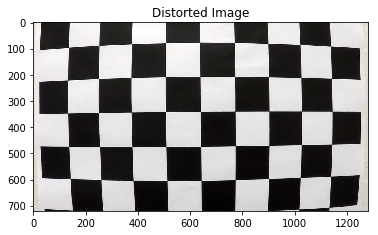

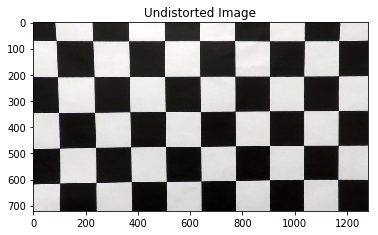

In [3]:
# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = calibrate(calibration_files, calibration_dim, True)

# test undistortion using one of the calibration files
test_undistort('camera_cal/calibration1.jpg', mtx, dist)

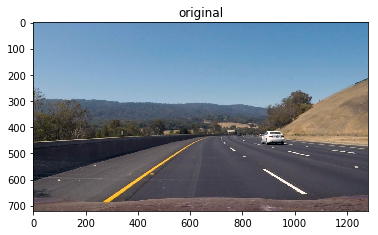

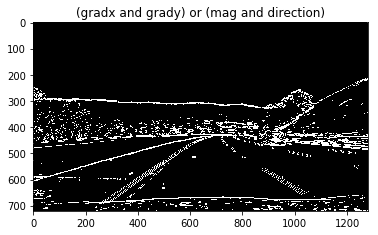

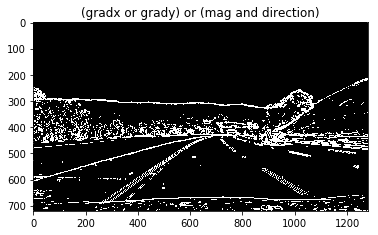

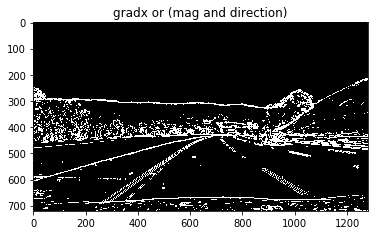

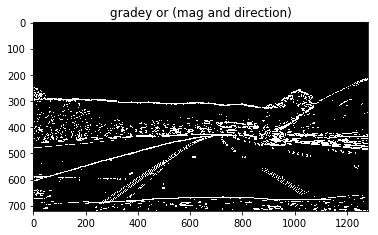

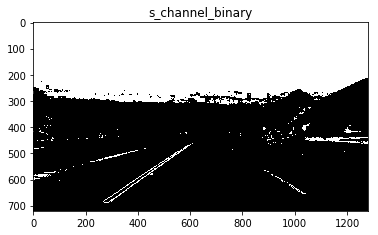

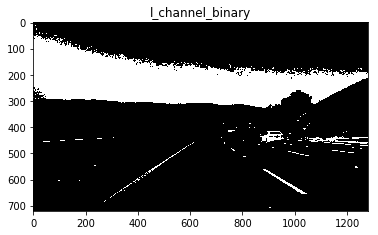

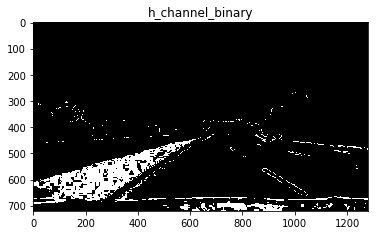

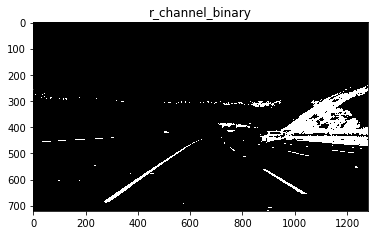

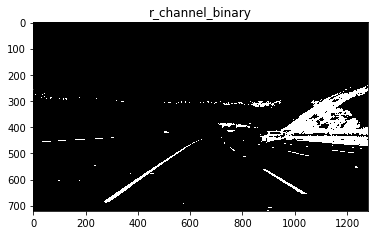

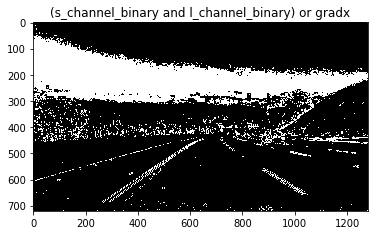

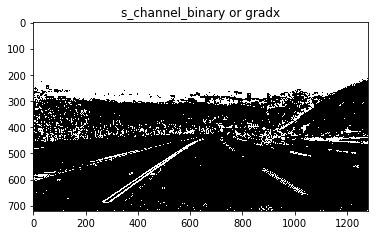

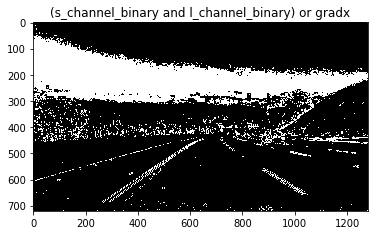

In [4]:
# Use test image and explore use of sobel gradients and various color schemes
SOBEL_KERNEL=9
img = cv2.imread(test_filename)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# get the gradient along x
gradx_binary = compute_sobel_grad_binary(img, 'x', SOBEL_KERNEL, (18, 80))

# get the gradient along y
grady_binary = compute_sobel_grad_binary(img, 'y', SOBEL_KERNEL, (18, 80))

# Using a slightly larger sobel kernel size to smooth out the binary threshold image
mag_binary = compute_sobel_mag_binary(img, SOBEL_KERNEL, (18, 90))

# get binary threshold based on gradient direction
dir_binary = compute_sobel_dir_binary(img, SOBEL_KERNEL, (np.pi/5, np.pi/2)) # (0.8, 1.8)

# Plot original image.  We convert BGR to RGB first before plotting b/c of the cv2.imread method used to read the image initially
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("original")
plt.show()

# define combination of thresholds
combined_binary = np.zeros_like(mag_binary)
combined_binary[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined_binary, cmap='gray')
plt.title("(gradx and grady) or (mag and direction)")
plt.show()

combined_binary = np.zeros_like(mag_binary)
combined_binary[((gradx_binary == 1) | (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined_binary, cmap='gray')
plt.title("(gradx or grady) or (mag and direction)")
plt.show()

# This combination seems to have less noise yet more defined than if looking along the y gradient
combined_binary = np.zeros_like(mag_binary)
combined_binary[((gradx_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined_binary, cmap='gray')
plt.title("gradx or (mag and direction)")
plt.show()

combined_binary = np.zeros_like(mag_binary)
combined_binary[((grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined_binary, cmap='gray')
plt.title("gradey or (mag and direction)")
plt.show()

s_channel_binary = compute_hls_channel_binary(img, 's', (90, 225)) # (170, 225) initial threshold
plt.imshow(s_channel_binary, cmap='gray')
plt.title("s_channel_binary")
plt.show()

l_channel_binary = compute_hls_channel_binary(img, 'l', (160, 255))
plt.imshow(l_channel_binary, cmap='gray')
plt.title("l_channel_binary")
plt.show()

h_channel_binary = compute_hls_channel_binary(img, 'h', (160, 255))
plt.imshow(h_channel_binary, cmap='gray')
plt.title("h_channel_binary")
plt.show()

r_channel_binary = compute_rgb_channel_binary(img, 'r', (160, 255))
plt.imshow(r_channel_binary, cmap='gray')
plt.title("r_channel_binary")
plt.show()

g_channel_binary = compute_rgb_channel_binary(img, 'g', (160, 255))
plt.imshow(r_channel_binary, cmap='gray')
plt.title("r_channel_binary")
plt.show()

# combine s-channel, r-channel and gradient x
combined_binary = np.zeros_like(s_channel_binary)
combined_binary[((s_channel_binary == 1) & (l_channel_binary == 1)) | (gradx_binary == 1) ] = 1
plt.imshow(combined_binary, cmap='gray')
plt.title("(s_channel_binary and l_channel_binary) or gradx")
plt.show()

# combine s-channel, r-channel and gradient x
combined_binary = np.zeros_like(s_channel_binary)
combined_binary[(s_channel_binary == 1) | (gradx_binary == 1) ] = 1
plt.imshow(combined_binary, cmap='gray')
plt.title("s_channel_binary or gradx")
plt.show()

# combine s-channel, l-channel and gradient x
combined_binary = np.zeros_like(s_channel_binary)
combined_binary[((s_channel_binary == 1) & (l_channel_binary == 1)) | (gradx_binary == 1) ] = 1

plt.imshow(combined_binary, cmap='gray')
plt.title("(s_channel_binary and l_channel_binary) or gradx")
plt.show()

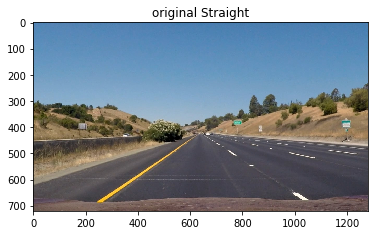

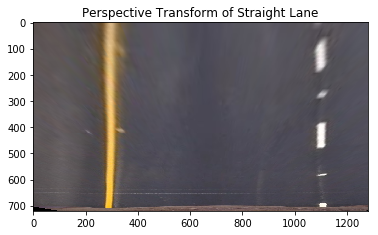

In [5]:
img_straight = cv2.imread(straight_filename)
rgb_straight = cv2.cvtColor(img_straight, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_straight)
plt.title("original Straight")
plt.show()

straight_perspective, M, Minv = perspective_transform(rgb_straight, perspective_src, perspective_dst)
plt.imshow(straight_perspective)
plt.title("Perspective Transform of Straight Lane")
plt.show()

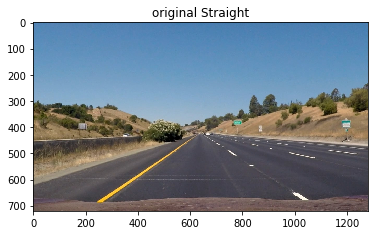

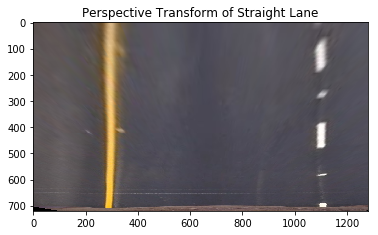

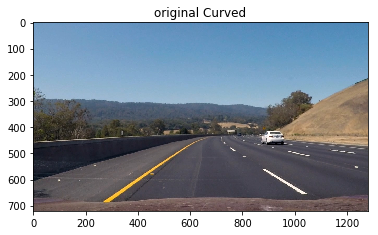

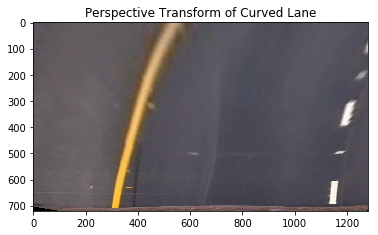

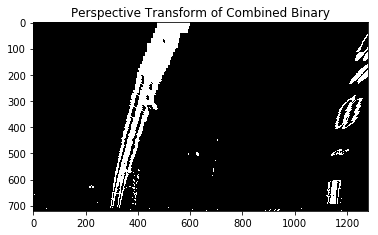

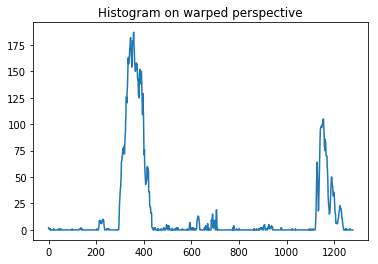

In [6]:
img_straight = cv2.imread(straight_filename)
rgb_straight = cv2.cvtColor(img_straight, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_straight)
plt.title("original Straight")
plt.show()

straight_perspective, M, Minv = perspective_transform(rgb_straight, perspective_src, perspective_dst)
plt.imshow(straight_perspective)
plt.title("Perspective Transform of Straight Lane")
plt.show()

# Try now to warp a curved lane image (test3.jpg)
# Use test image for testing gradient computation
img_curved = cv2.imread(curved_filename)  # this is a BGR image
rgb_curved = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_curved)
plt.title("original Curved")
plt.show()

curved_perspective, M, Minv = perspective_transform(rgb_curved, perspective_src, perspective_dst)
plt.imshow(curved_perspective)
plt.title("Perspective Transform of Curved Lane")
plt.show()

# Generate binary image from test image
combined_binary = generate_binary_image(img_curved)

# Now lets apply it to the binary combination image we chose
binary_warped, M, Minv = perspective_transform(combined_binary, perspective_src, perspective_dst)
plt.imshow(binary_warped, cmap='gray')
plt.title("Perspective Transform of Combined Binary")
plt.show()

# Generate a histogram on the warped_perspective
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.title("Histogram on warped perspective")
plt.plot(histogram)
plt.show()

In [7]:
def search_window_for_lanes(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 12 #9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100 #100
    # Set minimum number of pixels found to recenter window
    minpix = 50 #50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy

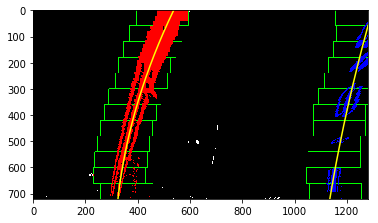

In [8]:
segmented, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = search_window_for_lanes(binary_warped)
plt.imshow(segmented)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [9]:
def search_window_polygon(binary_warped, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy):
    margin = 100 #100
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result

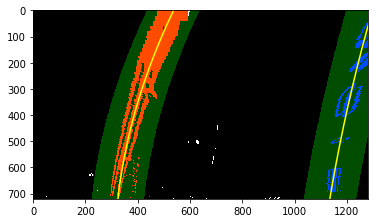

In [10]:
result = search_window_polygon(binary_warped, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [11]:
def fit_polynomial(left_fitx, right_fitx):

    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

    leftx = left_fitx
    rightx = right_fitx

    # Fit a second order polynomial to pixel positions in each lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, left_fitx, right_fitx, leftx, rightx

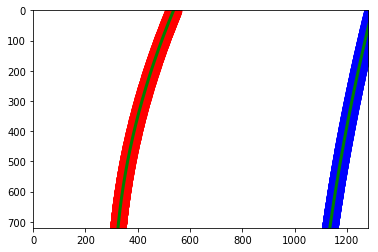

In [12]:
left_fit, right_fit, left_fitx, right_fitx, leftx, rightx = fit_polynomial(left_fitx, right_fitx)

# Plot up the data
mark_size = 15 #3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [13]:
# Calculate the curvature radius in pixels
def curvature_px(ploty, left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

In [14]:
# Define conversions in x and y from pixels space to meters
def curvature_meters(ploty, left_fitx, right_fitx):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad


In [15]:
print(curvature_px(ploty, left_fit, right_fit))
print(curvature_meters(ploty, left_fitx, right_fitx))

(1992.423024619141, 6313.0328021100704)
(642.60024353258052, 1991.7326509560053)


In [16]:
# Center calculation
def center_offset(img, leftx, rightx):
    xm_per_pix = 3.7/700
    image_height = img.shape[0]
    image_horizontal_center = img.shape[1]/2
    last_row_of_image = image_height - 1
    center_of_lane = (leftx[last_row_of_image] + rightx[last_row_of_image])/2
    car_offset = (image_horizontal_center - center_of_lane) * xm_per_pix
    return car_offset

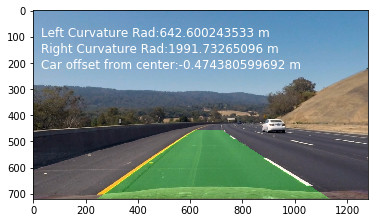

In [17]:
# Fill in the lane and doing a reverse mapping back to the original image

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

undist = cv2.undistort(rgb, mtx, dist, None, mtx)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (rgb.shape[1], rgb.shape[0])) 

left_curverad, right_curverad = curvature_meters(ploty, left_fitx, right_fitx)
car_offset = center_offset(img, leftx, rightx)

# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.text(30, 100,'Left Curvature Rad:'+str(left_curverad)+' m', fontsize=12, color='white')
plt.text(30, 160,'Right Curvature Rad:'+str(right_curverad)+' m', fontsize=12, color='white')
plt.text(30, 220,'Car offset from center:'+str(car_offset)+' m', fontsize=12, color='white')
plt.show()

In [18]:
def process_image(img):
    # Generate binary image from test image
    combined_binary = generate_binary_image(img)

    # Now lets apply it to the binary combination image we chose
    binary_warped, M, Minv = perspective_transform(combined_binary, perspective_src, perspective_dst)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    segmented, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = search_window_for_lanes(binary_warped)
    left_fit, right_fit, left_fitx, right_fitx, leftx, rightx = fit_polynomial(left_fitx, right_fitx)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (rgb.shape[1], rgb.shape[0])) 

    left_curverad, right_curverad = curvature_meters(ploty, left_fitx, right_fitx)
    car_offset = center_offset(img, leftx, rightx)

    # Combine the result with the original image
    cv2.putText(undist,'Left Curvature Rad:'+str(round(left_curverad,4))+' m', (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255))
    cv2.putText(undist,'Right Curvature Rad:'+str(round(right_curverad,4))+' m', (30, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255))
    cv2.putText(undist,'Car offset from center:'+str(round(car_offset,4))+' m', (30, 220), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255))
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
#from IPython.display import HTML

output = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:13<00:00,  6.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 4min 4s, sys: 6.73 s, total: 4min 11s
Wall time: 3min 13s
